This notebook is intended to use the Vision Transformer Turotial of Keras

Link: https://keras.io/examples/vision/image_classification_with_vision_transformer/

## If I do patch size of 300X300 and Image Size 3000x3000, then number of patches are 100

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from collections import Counter
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K

# Preparing the Data CSV

In [2]:
train_csv = pd.read_csv("..\\train.csv") 
print(train_csv.head())

   image_id label  image_width  image_height  is_tma
0         4  HGSC        23785         20008   False
1        66  LGSC        48871         48195   False
2        91  HGSC         3388          3388    True
3       281  LGSC        42309         15545   False
4       286    EC        37204         30020   False


In [3]:
modified_train_csv = train_csv.copy()

In [4]:
train_path = "..\\train_images"
train_thumbnail_path = "..\\train_thumbnails"


In [5]:
new_column = []
for i in range(len(train_csv)):
    if (train_csv["is_tma"].iloc[i] == False):
        new_column.append(os.path.join(train_thumbnail_path, str(train_csv["image_id"].iloc[i]) + "_thumbnail.png"))
    else:
        new_column.append("")

In [6]:
modified_train_csv["image_path"] = new_column
modified_train_csv.head()

,image_id,label,image_width,image_height,is_tma,image_path
0,4,HGSC,23785,20008,False,..\train_thumbnails\4_thumbnail.png
1,66,LGSC,48871,48195,False,..\train_thumbnails\66_thumbnail.png
2,91,HGSC,3388,3388,True,
3,281,LGSC,42309,15545,False,..\train_thumbnails\281_thumbnail.png
4,286,EC,37204,30020,False,..\train_thumbnails\286_thumbnail.png


In [7]:
modified_train_csv = modified_train_csv[modified_train_csv['image_path'] != '']
modified_train_csv = modified_train_csv.reset_index(drop=True)

In [8]:
# Create a test data out of this modified train csv
def getTheSplitData(csv):
    trainDf, testDf = train_test_split(csv, test_size=0.2, random_state=42, shuffle=True)
    return trainDf, testDf        

trainDf, validDf = getTheSplitData(modified_train_csv)

In [9]:
df_one_hot = pd.get_dummies(trainDf["label"], prefix="label").astype(int)
df_one_hot.head()

,label_CC,label_EC,label_HGSC,label_LGSC,label_MC
320,0,0,0,1,0
329,0,0,1,0,0
173,0,1,0,0,0
272,0,0,0,1,0
492,1,0,0,0,0


In [10]:
trainData = pd.concat([trainDf["image_id"], df_one_hot], axis=1)
trainData.head()

,image_id,label_CC,label_EC,label_HGSC,label_LGSC,label_MC
320,39258,0,0,0,1,0
329,39893,0,0,1,0,0
173,21373,0,1,0,0,0
272,34688,0,0,0,1,0
492,63015,1,0,0,0,0


In [11]:
train_thumbnail_paths = ""
trainData["image_path"] = trainDf['image_path']
trainData.head()

,image_id,label_CC,label_EC,label_HGSC,label_LGSC,label_MC,image_path
320,39258,0,0,0,1,0,..\train_thumbnails\39258_thumbnail.png
329,39893,0,0,1,0,0,..\train_thumbnails\39893_thumbnail.png
173,21373,0,1,0,0,0,..\train_thumbnails\21373_thumbnail.png
272,34688,0,0,0,1,0,..\train_thumbnails\34688_thumbnail.png
492,63015,1,0,0,0,0,..\train_thumbnails\63015_thumbnail.png


In [12]:
image_paths = trainData["image_path"].values
labels = trainData[[col for col in trainData.columns if col.startswith("label_")]].values
print(image_paths[0:5])
print(labels[0:5])

['..\\train_thumbnails\\39258_thumbnail.png'
 '..\\train_thumbnails\\39893_thumbnail.png'
 '..\\train_thumbnails\\21373_thumbnail.png'
 '..\\train_thumbnails\\34688_thumbnail.png'
 '..\\train_thumbnails\\63015_thumbnail.png']
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]]


In [13]:
# Creating the Input Data Pipeline
def read_image(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_png(file, 3)
    image = tf.image.resize(image, [3000, 3000], method='nearest')
    image = tf.image.per_image_standardization(image)
    return image

In [14]:
batch_size = 8


x = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    )
y = tf.data.Dataset.from_tensor_slices(labels)

# Zip the x and y together
ds = tf.data.Dataset.zip((x, y))

# Create the training and validation splits
val_ds = (
    ds
    .take(50)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds = (
    ds
    .skip(50)
    .shuffle(batch_size * 10)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Model Creation

## Configuring Hyperparameters

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 3000  # We'll resize input images to this size
patch_size = 256  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 512
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # 

## Implement multilayer perceptron (MLP)

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [17]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images, 
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID'
                                          )
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


..\train_thumbnails\11431_thumbnail.png


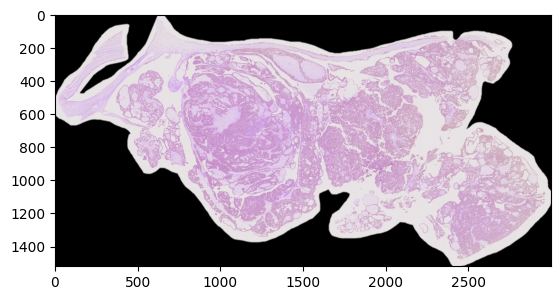

In [18]:
image_path = trainData.sample(1)['image_path'].values[0]
print(image_path)
image = cv2.imread(image_path)
plt.imshow(image.astype("uint8"))

..\train_thumbnails\56947_thumbnail.png
Raw Image Size :  (1327, 3000, 3)
Image size: 3000 X 3000
Patch size: 256 X 256
Patches per image: 121
Elements per patch: 196608


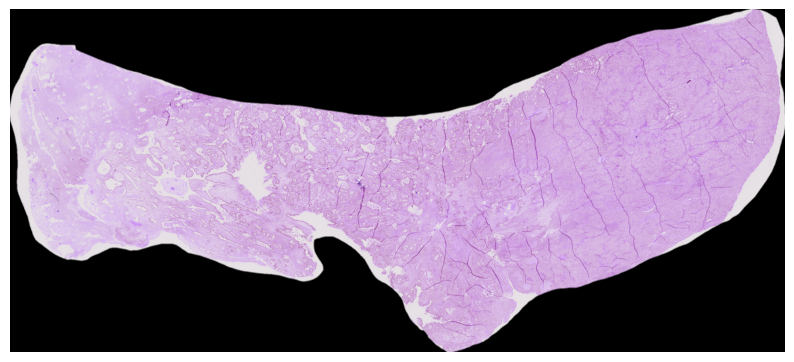

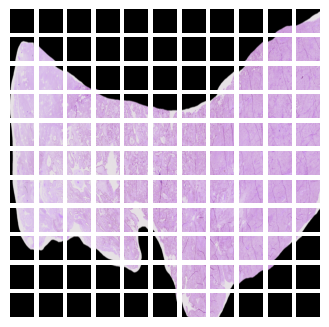

In [19]:
plt.figure(figsize=(10, 10))
image_path = trainData.sample(1)['image_path'].values[0]
print(image_path)
image = cv2.imread(str(image_path))
print("Raw Image Size : ", image.shape)
plt.imshow(image.astype("uint8"))
plt.grid()
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = (tf.reshape(patch, (patch_size, patch_size, 3))).numpy()
    plt.imshow((patch_img).astype("uint8"))
    plt.axis("off")
    

## Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size **projection_dim**. 

In addition, it adds a learnable position embedding to the projected vector.

In [20]:

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim): # Here I have hardcoded 121 for patches 256, 256 and image size of 3000X3000
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            K.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


# Build the ViT Model

In [21]:
def create_vit_classifier(num_classes):
    inputs = tf.keras.Input(shape=(3000, 3000, 3))
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches=121, projection_dim=projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


In [22]:
vit_classifier = create_vit_classifier(num_classes=5)

In [23]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3000, 3000,  0           []                               
                                 3)]                                                              
                                                                                                  
 patches_1 (Patches)            (None, 121, 196608)  0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 121, 512)     100725760   ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 121, 512)    1024        ['patch_encoder[0][0]']      

In [24]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy")
        ],
    )
    """
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    """
    history = model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data = val_ds
        
        #callbacks=[checkpoint_callback],
    )

    #model.load_weights(checkpoint_filepath)
    #_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [25]:
history = run_experiment(vit_classifier)

Epoch 1/10
45/45 [==============================] - 107s 2s/step - loss: 79.2822 - accuracy: 0.2750 - val_loss: 73.4990 - val_accuracy: 0.1400
Epoch 2/10
45/45 [==============================] - 95s 2s/step - loss: 60.5572 - accuracy: 0.2861 - val_loss: 14.0071 - val_accuracy: 0.1800
Epoch 3/10
45/45 [==============================] - 119s 2s/step - loss: 27.8614 - accuracy: 0.3139 - val_loss: 21.0241 - val_accuracy: 0.2400
Epoch 4/10
45/45 [==============================] - 137s 3s/step - loss: 18.4652 - accuracy: 0.3278 - val_loss: 12.7872 - val_accuracy: 0.3400
Epoch 5/10
45/45 [==============================] - 135s 2s/step - loss: 17.6826 - accuracy: 0.3639 - val_loss: 10.6341 - val_accuracy: 0.2800
Epoch 6/10
45/45 [==============================] - 118s 2s/step - loss: 10.6860 - accuracy: 0.3667 - val_loss: 2.2059 - val_accuracy: 0.3200
Epoch 7/10
45/45 [==============================] - 132s 2s/step - loss: 3.9032 - accuracy: 0.3722 - val_loss: 2.0378 - val_accuracy: 0.3600
Epo

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

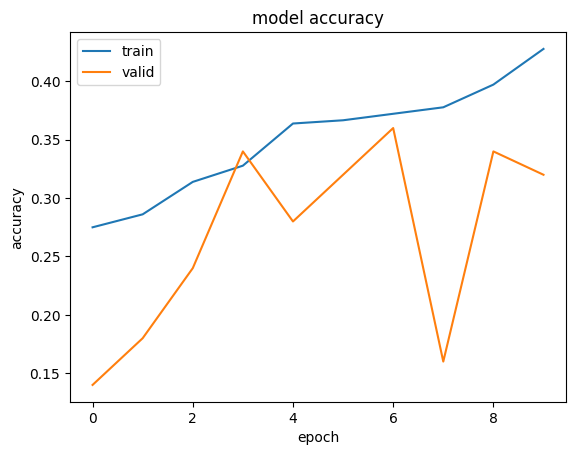

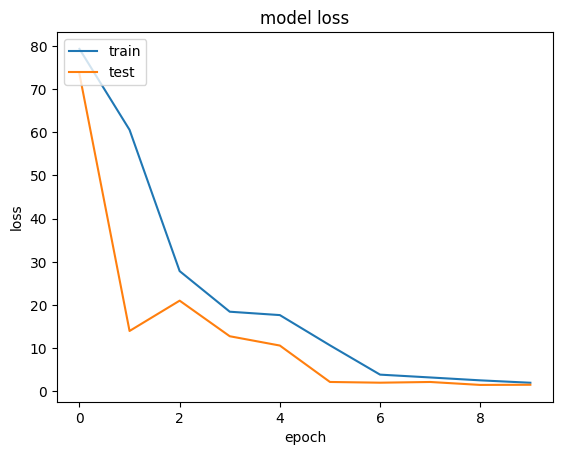

In [28]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('..\\training_graphs\\vit_trial1_accuracy_02_01_2024.png')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('..\\training_graphs\\vit_trial1_loss_02_01_2024.png')
    plt.show()
    

plot_history(history)